<a href="https://colab.research.google.com/github/Kaproc/proyecto-inundaciones-Grupo-2/blob/main/Aprendizaje_Automatico_Proyecto_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clasificación del Riesgo de Inundación por Parroquias en Zonas Lluviosas del Ecuador**

**Asignatura:** Aprendizaje Automático

**Elaborado por:** Alcívar Macay Anthony, Mejía
Nazareno Jean, Mora Reyes Cristopher,
Odelanti Díaz Jéssica, Quintana Plúas Luis

**Docente:** Ing. Botto Tobar Miguel

Link repositorio en Github : https://github.com/Kaproc/proyecto-inundaciones-Grupo-2/tree/main

URL Pública en Render https://proyecto-inundaciones-grupo-2.onrender.com/

Pruebas del modelo funcionando : https://1drv.ms/f/c/c270ba6a359cff01/IgDqKCSM8gCCQpt2DJyehsW7AfzVbFb54mF0sUJdnhCsdSc?e=dPyiZj

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import shutil
import requests
from flask import Flask, render_template_string, send_from_directory
from google.colab.output import eval_js
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

Descargar archivos desde el drive

In [7]:
!pip -q install gdown

#import pandas as pd

# Descargar carpeta completa
!gdown --folder "https://drive.google.com/drive/folders/1Wkz2Tg6ViSVGZSRm9zi6_xrk1N8_czHm" -O datos

# Cargar los 3 archivos requeridos
base = "/content/datos"

df = pd.read_excel(f"{base}/Base_Eventos_2010_2023_eventos_catálogo.xlsx", sheet_name="Base20102022")
df_clima = pd.read_csv(f"{base}/ecu-rainfall-subnat-full.csv")
df_postal = pd.read_excel(f"{base}/LISTADO-CODIGOS-POSTALES.xlsx", sheet_name="Hoja1")


Retrieving folder contents
Processing file 1uhsaaosMsR_hkylLdJ_wOACFyHHsjaF- Base_Eventos_2010_2023_eventos_catálogo.xlsx
Processing file 1SHE3Pv_os0bL-IqT3cEO7LMFbChOsDvK CODIFICACIÓN_2025.xlsx
Processing file 16yQAp8HblCzhwY1obaI8s2YHEp8KCCGD ecu-rainfall-subnat-full.csv
Processing file 1oG_kuwknf-V9XlgBX46FRzigvTTOpzzq LISTADO-CODIGOS-POSTALES.xlsx
Processing file 1u8uvcR8Mf5U3bXqbu8Qv2wiKJuhilCbJ ORGANIZACION TERRITORIAL DEL ESTADO PARROQUIAL (1).json
Processing file 1SCXge-S1Ov0mvQjAh36c8VdG8lh1I5v5 ORGANIZACION TERRITORIAL DEL ESTADO PARROQUIAL.shp
Processing file 1oBLdLOrhf78O67jmmSOu_45UZg1LWtFK predicciones_modelo_final_con_id.csv
Processing file 1i5s18x6I-TKmvLjDIiyjrpKH3LD9Q54Y predicciones_modelo_final.csv
Processing file 1CMFX_z2xlSvsTeRgjYtP2W4hZbF7Nixk predicciones_nacional_completo.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1uhsaaosMsR_hkylLdJ_wOACFyHHsj

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# **Origen y preparación de los datos**

Para el desarrollo del proyecto se integraron tres fuentes de datos principales:

**Base de eventos históricos (2010–2023)**

Contiene registros oficiales de eventos adversos en Ecuador, incluyendo información espacial (provincia, cantón, parroquia), temporal (fecha, año, mes) y de impacto humano (personas afectadas, damnificadas y fallecidas).
De esta base se filtraron únicamente los eventos cuya causa fue la lluvia y cuyo tipo de evento corresponde a inundaciones.

Camacho, C. (2023). Eventos de inundación de Ecuador 2010-2023, HydroShare, https://www.hydroshare.org/resource/e7a4a44bed0d408b958b682b8fa237c3/

**Dataset climático de precipitación**

Proporciona información histórica de precipitación a nivel subnacional, identificada mediante códigos territoriales oficiales (PCODE).
A partir de este dataset se utilizó la precipitación promedio histórica a nivel cantonal.
https://data.humdata.org/dataset/ecu-rainfall-subnational

**Dataset administrativo–poblacional**

Incluye la división político-administrativa del país y datos de población.
La población fue agregada a nivel cantonal para mantener consistencia con el nivel territorial del análisis climático.

https://regulacion.mintel.gob.ec/descargue-productos-del-sistema-codigo-postal-ecuatoriano/

Todos los datasets fueron limpiados eliminando valores faltantes en variables clave, corrigiendo formatos y evitando duplicaciones derivadas del cruce de información.

In [8]:
df

,IDBASEANT,ID,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,COMUNIDAD/BARRIO/SECTOR,LATITUD,...,Personas Impactadas,CODIFICACION PROVINCIAL-VAL,CANTON-VAL,CODIFICACION CANTONAL-VAL,PARROQUIAS-VAL,CODIFICACION PARROQUIAL-VAL,LATITUD-VAL,LONGITUD-VAL,val,AGROPECUARIA
0,1.0,1.0,Azuay,1,Cuenca,101,Molleturo,10157,"Tanzaray, Chacanseo",-2.717509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2.0,2.0,Azuay,1,Santa Isabel,108,Santa Isabel (Chaguarurco),10850,Vía Santa Isabel - Pasaje,-3.288058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,3.0,3.0,Azuay,1,Sevilla De Oro,113,Amaluza,11351,vía Guarumales - Méndez km15,-2.596527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,4.0,4.0,Azuay,1,Cuenca,101,Victoria Del Portete (Irquis),10171,"Altarloma, Sombrederas, Duraznos",-3.071833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,5.0,5.0,Azuay,1,Nabon,104,Nabon,10450,Nabón,-3.337235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
61026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
61027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
61028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [9]:
print(df.columns)

Index(['IDBASEANT', 'ID', 'PROVINCIA', 'CODIFICACION PROVINCIAL', 'CANTON',
       'CODIFICACION CANTONAL', 'PARROQUIAS', 'CODIFICACION PARROQUIAL',
       'COMUNIDAD/BARRIO/SECTOR', 'LATITUD', 'LONGITUD', 'EVENTO', 'CAUSA',
       'CATEGORIA DEL EVENTO', 'FECHA DEL EVENTO', 'MES', 'HORA DEL EVENTO',
       'FECHA DEL INFORME ', 'NUMERO DE INFORME NACIONAL',
       'CODIDO RED MONITOREO', 'NUMERO DE INFORME PROVINCIAL', 'FALLECIDAS',
       'HERIDAS', 'PERSONAS DESAPARECIDAS', 'FAMILIAS AFECTADAS',
       'PERSONAS AFECTADAS DIRECTAMENTE', 'AFECTADAS INDIRECTAS',
       'FAMILIAS DAMNIFICADAS', 'PERSONAS DAMNIFICADAS', 'PERSONAS EVACUADAS',
       'PERSONAS ALBERGADAS', 'P. EN FAMILIAS ACOGIENTES',
       'PERSONAS EN\n  OTROS MEDIOS', 'PERSONAS EN PROCESO DE EVACUACION',
       'PERSONAS QUE RESISTEN A LA EVACUACION', 'VIVIENDAS AFECTADAS',
       'VIVIENDAS DESTRUIDAS', 'ESTABLECIMIENTOS EDUCATIVOS AFECTADOS',
       'ESTABLECIMIENTOS EDUCATIVOS DESTRUIDOS', 'CENTROS DE SALUD AFECTAD

In [10]:
df = df[df['CAUSA'].str.contains('lluv', case=False, na=False)]


In [11]:
df['CAUSA'].value_counts()


,count
CAUSA,
Lluvias,15398


In [12]:
df['CAUSA'].unique()


array(['Lluvias'], dtype=object)

In [13]:
df

,IDBASEANT,ID,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,COMUNIDAD/BARRIO/SECTOR,LATITUD,...,Personas Impactadas,CODIFICACION PROVINCIAL-VAL,CANTON-VAL,CODIFICACION CANTONAL-VAL,PARROQUIAS-VAL,CODIFICACION PARROQUIAL-VAL,LATITUD-VAL,LONGITUD-VAL,val,AGROPECUARIA
0,1.0,1.0,Azuay,1,Cuenca,101,Molleturo,10157,"Tanzaray, Chacanseo",-2.717509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2.0,2.0,Azuay,1,Santa Isabel,108,Santa Isabel (Chaguarurco),10850,Vía Santa Isabel - Pasaje,-3.288058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,10.0,10.0,Azuay,1,Gualaceo,103,Jadan,10353,Tocteloma,-2.888019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
11,12.0,12.0,Azuay,1,Cuenca,101,Llacao,10156,La Unión,-2.844229,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
12,13.0,13.0,Azuay,1,Chordeleg,111,La Union,11152,Zhucus,-2.925302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51540,NaN,51542.0,Zamora Chinchipe,19,Zamora,1901,Guadalupe,190152,"San Antonio, vía Guadalupe _Yacuambi [E50]",-3.920829,...,NaN,19.0,Zamora,1901.0,Guadalupe,190152.0,-3.920829,-78.951037,#REF!,0.0
51541,NaN,51543.0,Zamora Chinchipe,19,Zamora,1901,Sabanilla,190155,"El Destrozo, Vía Loja- Zamora [E50]",-4.040339,...,NaN,19.0,Zamora,1901.0,Sabanilla,190155.0,-4.040339,-79.013407,#REF!,0.0
51542,NaN,51544.0,Zamora Chinchipe,19,Zamora,1901,Sabanilla,190155,"El Tambo, vía – Zamora - Loja E50",-3.950717,...,NaN,19.0,Zamora,1901.0,Sabanilla,190155.0,-3.950717,-79.046733,#REF!,0.0
51543,NaN,51545.0,Zamora Chinchipe,19,Palanda,1908,Palanda,190850,"Numbala, vía San Francisco del Vergel- Numbala...",-4.659145,...,NaN,19.0,Palanda,1908.0,Palanda,190850.0,-4.659145,-79.233534,#REF!,0.0


In [14]:
columnas_utiles = [
    'PROVINCIA',
    'CODIFICACION PROVINCIAL',
    'CANTON',
    'CODIFICACION CANTONAL',
    'PARROQUIAS',
    'CODIFICACION PARROQUIAL',
    'LATITUD',
    'LONGITUD',
    'EVENTO',
    'CATEGORIA DEL EVENTO',
    'CAUSA',
    'FECHA DEL EVENTO',
    'AÑO',
    'MES',
    'PERSONAS AFECTADAS DIRECTAMENTE',
    'PERSONAS DAMNIFICADAS',
    'FAMILIAS AFECTADAS',
    'FALLECIDAS'
]


In [15]:
df = df[columnas_utiles]

In [16]:
df = df[df['EVENTO'].str.contains('inund', case=False, na=False)]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4182 entries, 0 to 51523
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   PROVINCIA                        4182 non-null   object        
 1   CODIFICACION PROVINCIAL          4182 non-null   object        
 2   CANTON                           4182 non-null   object        
 3   CODIFICACION CANTONAL            4182 non-null   object        
 4   PARROQUIAS                       4182 non-null   object        
 5   CODIFICACION PARROQUIAL          4182 non-null   object        
 6   LATITUD                          4182 non-null   float64       
 7   LONGITUD                         4182 non-null   float64       
 8   EVENTO                           4182 non-null   object        
 9   CATEGORIA DEL EVENTO             4182 non-null   object        
 10  CAUSA                            4182 non-null   object        


In [18]:
df

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,CAUSA,FECHA DEL EVENTO,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,Lluvias,2010-03-18,2010.0,3.0,750.0,0.0,187.5,0.0
31,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,Lluvias,2010-03-02,2010.0,3.0,0.0,0.0,0.0,0.0
36,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-03,2010.0,4.0,100.0,0.0,25.0,0.0
39,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0
40,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51517,Zamora Chinchipe,19,Centinela Del Cóndor,1907,Triunfo-Dorado,190752,-3.935038,-78.704581,INUNDACIÓN,Época Lluviosa,Lluvias,2021-11-02,2021.0,11.0,60.0,0.0,20.0,0.0
51520,Zamora Chinchipe,19,Chinchipe,1902,Zumba,190250,-4.859691,-79.133198,INUNDACIÓN,Época Lluviosa,Lluvias,2021-11-16,2021.0,11.0,16.0,0.0,4.0,0.0
51521,Zamora Chinchipe,19,Yantzaza,1905,Los Encuentros,190553,-3.761991,-78.653250,INUNDACIÓN,Época Lluviosa,Lluvias,2021-11-16,2021.0,11.0,7.0,0.0,2.0,0.0
51522,Zamora Chinchipe,19,Nangaritza,1903,Guayzimi,190350,-4.053117,-78.681305,INUNDACIÓN,Época Lluviosa,Lluvias,2021-11-17,2021.0,11.0,0.0,0.0,3.0,0.0


In [19]:
df['pcode_canton'] = (
    'EC' + df['CODIFICACION CANTONAL'].astype(str).str.zfill(4)
)

In [20]:
df_clima_canton = (
    df_clima[df_clima['adm_level'] == 2]
    .groupby('PCODE', as_index=False)['rfh_avg']
    .mean()
    .rename(columns={'rfh_avg': 'precipitacion_promedio_mm'})
)

In [21]:
df_postal_limpio = df_postal[
    ['dpa_provin', 'dpa_despro', 'dpa_canton', 'dpa_descan', 'Poblacion']
].dropna()

df_postal_limpio['pcode_canton'] = (
    'EC' + df_postal_limpio['dpa_canton'].astype(str).str.zfill(4)
)

In [22]:
df_postal_canton = (
    df_postal_limpio
    .groupby('pcode_canton', as_index=False)
    .agg({
        'dpa_provin': 'first',
        'dpa_despro': 'first',
        'dpa_canton': 'first',
        'dpa_descan': 'first',
        'Poblacion': 'sum'
    })
)

In [23]:
df.head()

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,CAUSA,FECHA DEL EVENTO,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS,pcode_canton
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,Lluvias,2010-03-18,2010.0,3.0,750.0,0.0,187.5,0.0,EC0101
31,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,Lluvias,2010-03-02,2010.0,3.0,0.0,0.0,0.0,0.0,EC0207
36,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-03,2010.0,4.0,100.0,0.0,25.0,0.0,EC0204
39,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0,EC0205
40,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,Lluvias,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0,EC0205


# **Selección de las variables predictoras**

Las variables seleccionadas como características del modelo fueron:

**-precipitacion_promedio_mm**

Variable derivada que representa la precipitación promedio histórica por cantón.
Se seleccionó debido a que la intensidad y recurrencia de lluvias es un factor determinante en la ocurrencia de inundaciones.

**-Poblacion_Cantonal**

Representa la población total del cantón.
Esta variable se incluyó como un indicador de exposición y vulnerabilidad, ya que cantones con mayor población tienden a presentar un mayor impacto humano ante eventos de inundación.

In [24]:
df = df.merge(
    df_clima_canton,
    left_on='pcode_canton',
    right_on='PCODE',
    how='left'
)
df = df.drop(columns=['PCODE'])

In [25]:
df = df.merge(
    df_postal_canton,
    on='pcode_canton',
    how='left'
)
df = df.drop(columns=['dpa_provin', 'dpa_despro','dpa_canton','dpa_descan' ])
df.rename(columns={'Poblacion': 'Poblacion_Cantonal'}, inplace=True)


In [26]:
df

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,...,FECHA DEL EVENTO,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS,pcode_canton,precipitacion_promedio_mm,Poblacion_Cantonal
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,...,2010-03-18,2010.0,3.0,750.0,0.0,187.5,0.0,EC0101,23.575731,505882.0
1,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,...,2010-03-02,2010.0,3.0,0.0,0.0,0.0,0.0,EC0207,43.085463,6136.0
2,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,...,2010-04-03,2010.0,4.0,100.0,0.0,25.0,0.0,EC0204,46.479907,12114.0
3,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,...,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0
4,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,...,2010-04-08,2010.0,4.0,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,Zamora Chinchipe,19,Centinela Del Cóndor,1907,Triunfo-Dorado,190752,-3.935038,-78.704581,INUNDACIÓN,Época Lluviosa,...,2021-11-02,2021.0,11.0,60.0,0.0,20.0,0.0,EC1907,53.534114,6507.0
4178,Zamora Chinchipe,19,Chinchipe,1902,Zumba,190250,-4.859691,-79.133198,INUNDACIÓN,Época Lluviosa,...,2021-11-16,2021.0,11.0,16.0,0.0,4.0,0.0,EC1902,34.906355,9119.0
4179,Zamora Chinchipe,19,Yantzaza,1905,Los Encuentros,190553,-3.761991,-78.653250,INUNDACIÓN,Época Lluviosa,...,2021-11-16,2021.0,11.0,7.0,0.0,2.0,0.0,EC1905,56.278314,18677.0
4180,Zamora Chinchipe,19,Nangaritza,1903,Guayzimi,190350,-4.053117,-78.681305,INUNDACIÓN,Época Lluviosa,...,2021-11-17,2021.0,11.0,0.0,0.0,3.0,0.0,EC1903,59.140214,5194.0


In [27]:
df.duplicated().sum()

np.int64(45)

In [28]:
df = df.drop_duplicates()

In [29]:
df['AÑO'] = df['AÑO'].astype(int)
df['MES'] = df['MES'].astype(int)

/tmp/ipython-input-3483251950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AÑO'] = df['AÑO'].astype(int)
/tmp/ipython-input-3483251950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MES'] = df['MES'].astype(int)


In [30]:
df = df.dropna(
    subset=[
        'precipitacion_promedio_mm',
        'Poblacion_Cantonal'
    ]
)

In [31]:
df

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,...,FECHA DEL EVENTO,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS,pcode_canton,precipitacion_promedio_mm,Poblacion_Cantonal
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,...,2010-03-18,2010,3,750.0,0.0,187.5,0.0,EC0101,23.575731,505882.0
1,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,...,2010-03-02,2010,3,0.0,0.0,0.0,0.0,EC0207,43.085463,6136.0
2,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,...,2010-04-03,2010,4,100.0,0.0,25.0,0.0,EC0204,46.479907,12114.0
3,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,...,2010-04-08,2010,4,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0
4,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,...,2010-04-08,2010,4,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,Zamora Chinchipe,19,Centinela Del Cóndor,1907,Triunfo-Dorado,190752,-3.935038,-78.704581,INUNDACIÓN,Época Lluviosa,...,2021-11-02,2021,11,60.0,0.0,20.0,0.0,EC1907,53.534114,6507.0
4178,Zamora Chinchipe,19,Chinchipe,1902,Zumba,190250,-4.859691,-79.133198,INUNDACIÓN,Época Lluviosa,...,2021-11-16,2021,11,16.0,0.0,4.0,0.0,EC1902,34.906355,9119.0
4179,Zamora Chinchipe,19,Yantzaza,1905,Los Encuentros,190553,-3.761991,-78.653250,INUNDACIÓN,Época Lluviosa,...,2021-11-16,2021,11,7.0,0.0,2.0,0.0,EC1905,56.278314,18677.0
4180,Zamora Chinchipe,19,Nangaritza,1903,Guayzimi,190350,-4.053117,-78.681305,INUNDACIÓN,Época Lluviosa,...,2021-11-17,2021,11,0.0,0.0,3.0,0.0,EC1903,59.140214,5194.0


# **Construcción de la variable objetivo**

La variable objetivo del modelo es:

**-riesgo_inundacion**

Esta variable fue construida de forma binaria a partir del impacto humano registrado en cada evento:

Se asigna **1 (riesgo)** si el evento presenta al menos uno de los siguientes:

personas afectadas directamente,

personas damnificadas,

personas fallecidas.

Se asigna **0 (sin riesgo)** cuando no se registra impacto humano.

Tecnicamente, la variable objetivo se definió combinando los indicadores de impacto humano disponibles en el dataset de eventos, lo que permite operacionalizar el concepto de riesgo de inundación de manera objetiva y reproducible.

In [32]:
df['riesgo_inundacion'] = (
    (df['PERSONAS AFECTADAS DIRECTAMENTE'] > 0) |
    (df['PERSONAS DAMNIFICADAS'] > 0) |
    (df['FALLECIDAS'] > 0)
).astype(int)


In [33]:
df['riesgo_inundacion'].value_counts()


,count
riesgo_inundacion,
1,2801
0,1283


In [34]:
df.head()

,PROVINCIA,CODIFICACION PROVINCIAL,CANTON,CODIFICACION CANTONAL,PARROQUIAS,CODIFICACION PARROQUIAL,LATITUD,LONGITUD,EVENTO,CATEGORIA DEL EVENTO,...,AÑO,MES,PERSONAS AFECTADAS DIRECTAMENTE,PERSONAS DAMNIFICADAS,FAMILIAS AFECTADAS,FALLECIDAS,pcode_canton,precipitacion_promedio_mm,Poblacion_Cantonal,riesgo_inundacion
0,Azuay,1,Cuenca,101,Molleturo,10157,-2.717509,-79.397208,INUNDACIÓN,Época Lluviosa,...,2010,3,750.0,0.0,187.5,0.0,EC0101,23.575731,505882.0,1
1,Bolívar,2,Las Naves,207,Las Naves,20702,-1.286872,-79.292168,INUNDACIÓN,Época Lluviosa,...,2010,3,0.0,0.0,0.0,0.0,EC0207,43.085463,6136.0,0
2,Bolívar,2,Echeandía,204,Echeandia,20450,-1.473707,-79.312869,INUNDACIÓN,Época Lluviosa,...,2010,4,100.0,0.0,25.0,0.0,EC0204,46.479907,12114.0,1
3,Bolívar,2,San Miguel,205,San Miguel,20550,-1.722491,-79.051502,INUNDACIÓN,Época Lluviosa,...,2010,4,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0,0
4,Bolívar,2,San Miguel,205,Regulo De Mora,20553,-1.884385,-79.202489,INUNDACIÓN,Época Lluviosa,...,2010,4,0.0,0.0,0.0,0.0,EC0205,33.717648,27245.0,0


In [35]:
print("\nTipo de dato de la fecha:")
print(df['FECHA DEL EVENTO'].dtype)


Tipo de dato de la fecha:
datetime64[ns]


In [36]:
columnas_numericas = [
    'LATITUD',
    'LONGITUD',
    'PERSONAS AFECTADAS DIRECTAMENTE',
    'PERSONAS DAMNIFICADAS',
    'FAMILIAS AFECTADAS',
    'FALLECIDAS'
]

print("\nTipos de datos de columnas numéricas:")
print(df[columnas_numericas].dtypes)


Tipos de datos de columnas numéricas:
LATITUD                            float64
LONGITUD                           float64
PERSONAS AFECTADAS DIRECTAMENTE    float64
PERSONAS DAMNIFICADAS              float64
FAMILIAS AFECTADAS                 float64
FALLECIDAS                         float64
dtype: object


In [37]:
print("NaN por columna:")
print(df.isna().sum())

NaN por columna:
PROVINCIA                          0
CODIFICACION PROVINCIAL            0
CANTON                             0
CODIFICACION CANTONAL              0
PARROQUIAS                         0
CODIFICACION PARROQUIAL            0
LATITUD                            0
LONGITUD                           0
EVENTO                             0
CATEGORIA DEL EVENTO               0
CAUSA                              0
FECHA DEL EVENTO                   0
AÑO                                0
MES                                0
PERSONAS AFECTADAS DIRECTAMENTE    0
PERSONAS DAMNIFICADAS              0
FAMILIAS AFECTADAS                 0
FALLECIDAS                         0
pcode_canton                       0
precipitacion_promedio_mm          0
Poblacion_Cantonal                 0
riesgo_inundacion                  0
dtype: int64


# **EDA**

In [38]:
df_limpio = df.copy()

In [39]:
df_limpio['riesgo_inundacion'].value_counts()

,count
riesgo_inundacion,
1,2801
0,1283


In [40]:
df_limpio['riesgo_inundacion'].value_counts(normalize=True)

,proportion
riesgo_inundacion,
1,0.685847
0,0.314153


In [41]:
df_limpio['precipitacion_promedio_mm'].describe()

,precipitacion_promedio_mm
count,4084.000000
mean,42.415189
std,24.675896
min,2.443572
25%,23.073807
50%,35.445131
75%,53.534114
max,123.241577


La variable objetivo presenta un desbalance moderado, con aproximadamente el 68.7 % de los registros clasificados como riesgo de inundación y el 31.3 % como no riesgo. Si bien el desbalance no es extremo, se debe considerar su efecto en el entrenamiento y evaluación de los modelos de clasificación.

# **Boxplots por clase**

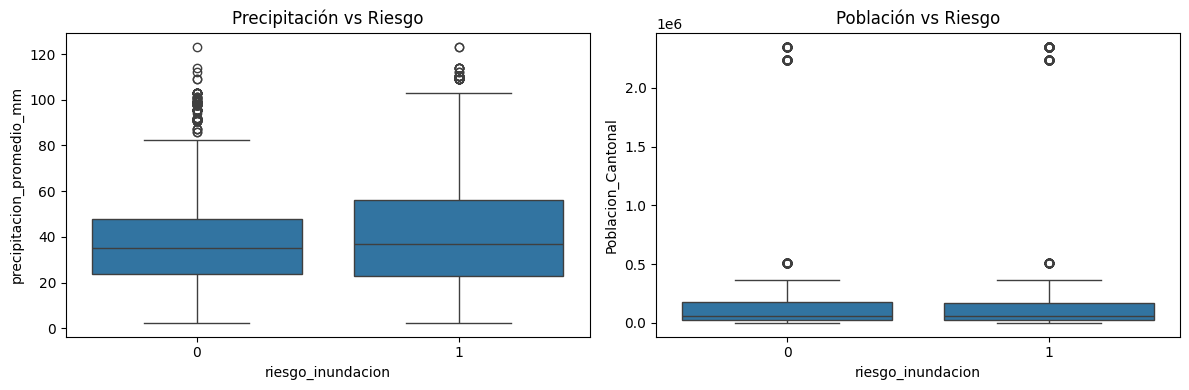

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(data=df_limpio, x='riesgo_inundacion',
            y='precipitacion_promedio_mm', ax=axs[0])
axs[0].set_title('Precipitación vs Riesgo')

sns.boxplot(data=df_limpio, x='riesgo_inundacion',
            y='Poblacion_Cantonal', ax=axs[1])
axs[1].set_title('Población vs Riesgo')

plt.tight_layout()
plt.show()

# **Distribución de variables numéricas (campana de Gauss) y Histogramas separados por clase**

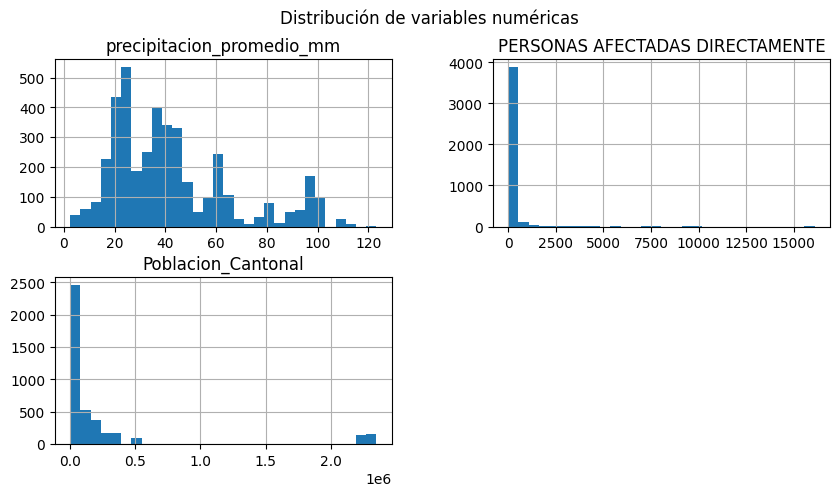

In [43]:
df_limpio[
    ['precipitacion_promedio_mm',
     'PERSONAS AFECTADAS DIRECTAMENTE',
     'Poblacion_Cantonal']
].hist(bins=30, figsize=(10,5))

plt.suptitle("Distribución de variables numéricas")
plt.show()

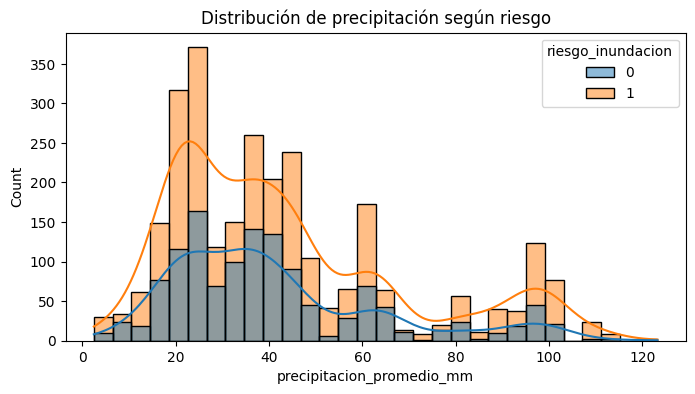

In [44]:
plt.figure(figsize=(8,4))

sns.histplot(data=df_limpio,
             x='precipitacion_promedio_mm',
             hue='riesgo_inundacion',
             bins=30,
             kde=True)

plt.title('Distribución de precipitación según riesgo')
plt.show()

# **Scatter plots (relación entre variables)**

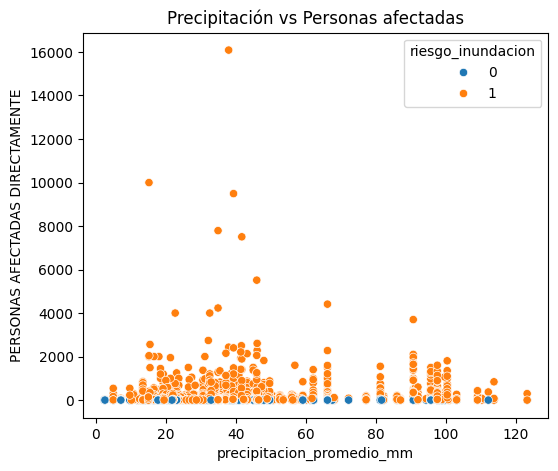

In [45]:
plt.figure(figsize=(6,5))

sns.scatterplot(
    data=df_limpio,
    x='precipitacion_promedio_mm',
    y='PERSONAS AFECTADAS DIRECTAMENTE',
    hue='riesgo_inundacion'
)

plt.title('Precipitación vs Personas afectadas')
plt.show()

# **Correlación de variables**

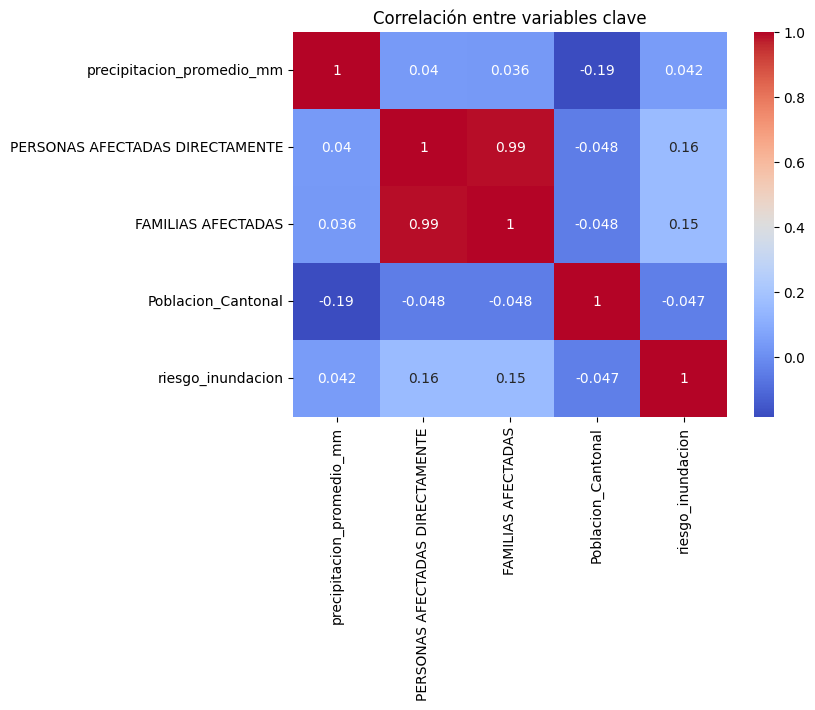

In [46]:
vars_corr = [
    'precipitacion_promedio_mm',
    'PERSONAS AFECTADAS DIRECTAMENTE',
    'FAMILIAS AFECTADAS',
    'Poblacion_Cantonal',
    'riesgo_inundacion'
]

plt.figure(figsize=(7,5))
sns.heatmap(
    df_limpio[vars_corr].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlación entre variables clave')
plt.show()

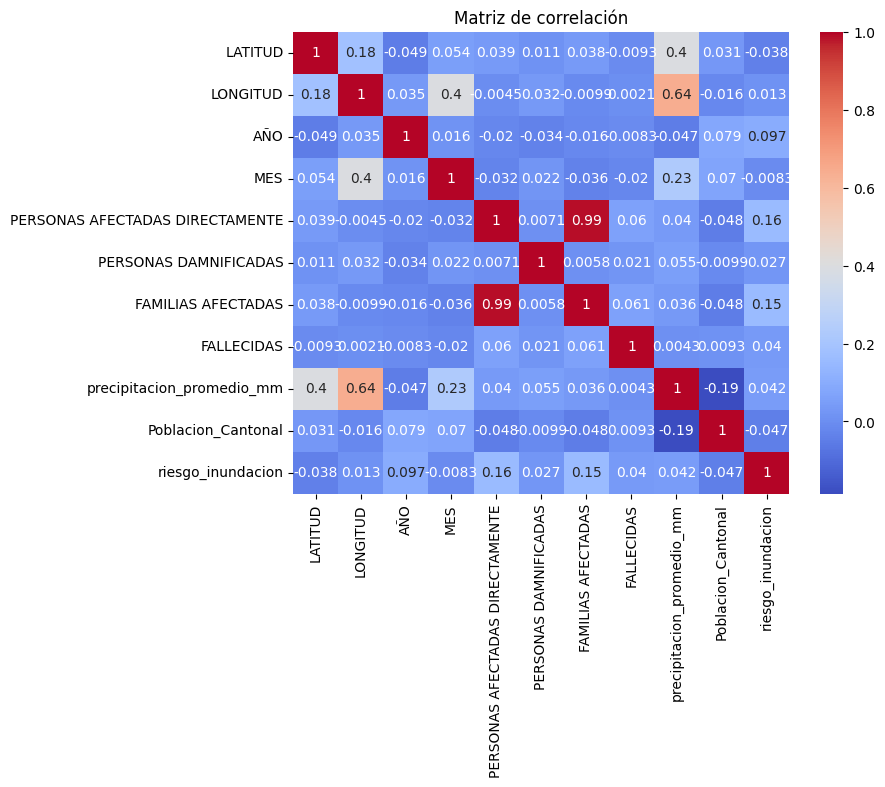

In [47]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    df_limpio.select_dtypes(include='number').corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Matriz de correlación")
plt.show()

# **Top 10 parroquias**

In [48]:
top_parroquias = (
    df_limpio[df_limpio['riesgo_inundacion'] == 1]
    .groupby(['PROVINCIA', 'CANTON', 'PARROQUIAS'])
    .agg({
        'precipitacion_promedio_mm': 'mean',
        'FALLECIDAS': 'sum',
        'PERSONAS AFECTADAS DIRECTAMENTE': 'sum'
    })
    .sort_values('precipitacion_promedio_mm', ascending=False)
    .head(10)
)

top_parroquias

precipitacion_promedio_mm  \
PROVINCIA CANTON                      PARROQUIAS                                               
Pastaza   Santa Clara                 Santa Clara                                 123.241577   
Orellana  Loreto                      Loreto                                      113.762838   
                                      San Jose De Dahuano                         113.762838   
                                      Puerto Murialdo                             113.762838   
Napo      Carlos Julio Arosemena Tola Carlos Julio Arosemena Tola                 112.146168   
Sucumbíos Cascales                    Sevilla                                     110.273869   
                                      El Dorado De Cascales                       110.273869   
Pastaza   Mera                        Shell                                       109.059489   
                                      Mera                                        109.059489   
                                      Madre Tierra                                109.059489   

                                                                   FALLECIDAS  \
PROVINCIA CANTON                      PARROQUIAS                                
Pastaza   Santa Clara                 Santa Clara                         0.0   
Orellana  Loreto                      Loreto                              0.0   
                                      San Jose De Dahuano                 0.0   
                                      Puerto Murialdo                     0.0   
Napo      Carlos Julio Arosemena Tola Carlos Julio Arosemena Tola         0.0   
Sucumbíos Cascales                    Sevilla                             0.0   
                                      El Dorado De Cascales               1.0   
Pastaza   Mera                        Shell                               0.0   
                                      Mera                                1.0   
                                      Madre Tierra                        0.0   

                                                                   PERSONAS AFECTADAS DIRECTAMENTE  
PROVINCIA CANTON                      PARROQUIAS                                                    
Pastaza   Santa Clara                 Santa Clara                                            297.0  
Orellana  Loreto                      Loreto                                                   1.0  
                                      San Jose De Dahuano                                    125.0  
                                      Puerto Murialdo                                        916.0  
Napo      Carlos Julio Arosemena Tola Carlos Julio Arosemena Tola                            374.0  
Sucumbíos Cascales                    Sevilla                                                 16.0  
                                      El Dorado De Cascales                                  149.0  
Pastaza   Mera                        Shell                                                  112.0  
                                      Mera                                                   400.0  
                                      Madre Tierra                                           688.0

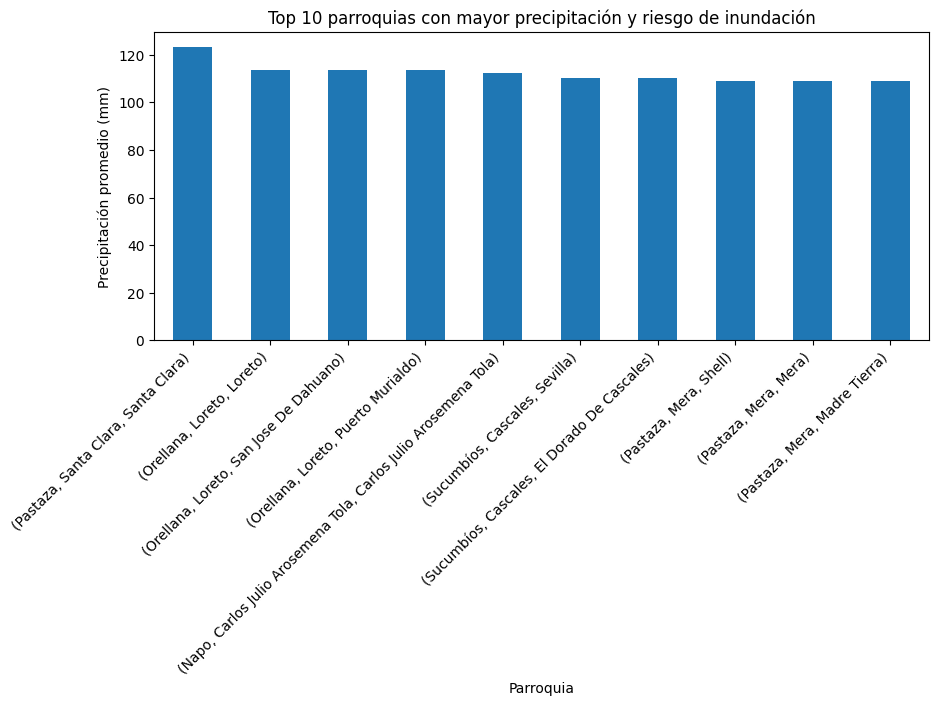

In [49]:
top_parroquias['precipitacion_promedio_mm'].plot(
    kind='bar',
    figsize=(10,4)
)

plt.title('Top 10 parroquias con mayor precipitación y riesgo de inundación')
plt.ylabel('Precipitación promedio (mm)')
plt.xlabel('Parroquia')
plt.xticks(rotation=45, ha='right')
plt.show()

Como parte del análisis exploratorio, se realizó un análisis territorial a nivel de parroquia, identificando aquellas con mayor precipitación promedio y riesgo de inundación, así como su impacto en términos de personas afectadas y fallecidas. Este análisis permite visualizar zonas críticas y aporta contexto al posterior modelado.

El análisis exploratorio permitió verificar la correcta estructura del dataset, identificar un desbalance moderado en la variable objetivo y analizar la relación entre la precipitación, el impacto humano y el riesgo de inundación. Las visualizaciones y estadísticas descriptivas muestran diferencias relevantes entre eventos con y sin riesgo, así como la existencia de parroquias con alta precipitación y afectaciones significativas. En conjunto, los resultados confirman que el dataset contiene información pertinente y suficiente para el entrenamiento de modelos de clasificación.

In [50]:
# Evaluación del balanceo de la variable objetivo
conteo_clases = df_limpio['riesgo_inundacion'].value_counts()
proporcion_clases = df_limpio['riesgo_inundacion'].value_counts(normalize=True)

print("Conteo de clases:")
print(conteo_clases)

print("\nProporción de clases:")
print(proporcion_clases)

Conteo de clases:
riesgo_inundacion
1    2801
0    1283
Name: count, dtype: int64

Proporción de clases:
riesgo_inundacion
1    0.685847
0    0.314153
Name: proportion, dtype: float64


# **Modelos**

## **Datos para modelado (X, y)**

In [51]:
# Variables predictoras (numéricas)
features = [
    'precipitacion_promedio_mm',
    'Poblacion_Cantonal',
    'LATITUD',
    'LONGITUD',
    'AÑO',
]

X = df_limpio[features]
y = df_limpio['riesgo_inundacion']

In [52]:
print("Dimensión X:", X.shape)
print("Distribución y:")
print(y.value_counts())

Dimensión X: (4084, 5)
Distribución y:
riesgo_inundacion
1    2801
0    1283
Name: count, dtype: int64


In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]} muestras")
print(f"Test set: {X_test.shape[0]} muestras")
print(f"Distribución de clases en train:\n{y_train.value_counts()}")

Train set: 2858 muestras
Test set: 1226 muestras
Distribución de clases en train:
riesgo_inundacion
1    1960
0     898
Name: count, dtype: int64


In [55]:
def evaluar_modelo(nombre, modelo, X_test, y_test, y_pred, y_prob=None):
    print(f"Evaluación: {nombre}")

    print("\nMatriz de confusión:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred))


    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1], [0,1], '--')
        plt.title(f"Curva ROC - {nombre}")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend()
        plt.show()

## **Regresión Logística**

In [56]:

lr_base = LogisticRegression(random_state=42, max_iter=1000)
lr_base.fit(X_train_scaled, y_train)
y_pred_lr_base = lr_base.predict(X_test_scaled)
y_proba_lr_base = lr_base.predict_proba(X_test_scaled)

print("\n--- Regresión Logística (Base) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_base):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr_base))


param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_lr,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_scaled, y_train)

print(f"\nMejores parámetros: {grid_lr.best_params_}")
print(f"Mejor score (CV Recall): {grid_lr.best_score_:.3f}")


y_pred_lr_opt = grid_lr.predict(X_test_scaled)
y_proba_lr_opt = grid_lr.predict_proba(X_test_scaled)

print("\nRegresión Logística (Optimizada)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_opt):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_lr_opt))


--- Regresión Logística (Base) ---
Accuracy: 0.691

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.02      0.04       385
           1       0.69      1.00      0.82       841

    accuracy                           0.69      1226
   macro avg       0.78      0.51      0.43      1226
weighted avg       0.75      0.69      0.57      1226

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Mejores parámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor score (CV Recall): 0.686

Regresión Logística (Optimizada)
Accuracy: 0.689

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       385
           1       0.69      1.00      0.82       841

    accuracy                           0.69      1226
   macro avg       0.84      0.51      0.42      1226
weighted avg       0.79      0.69      0.57      1226



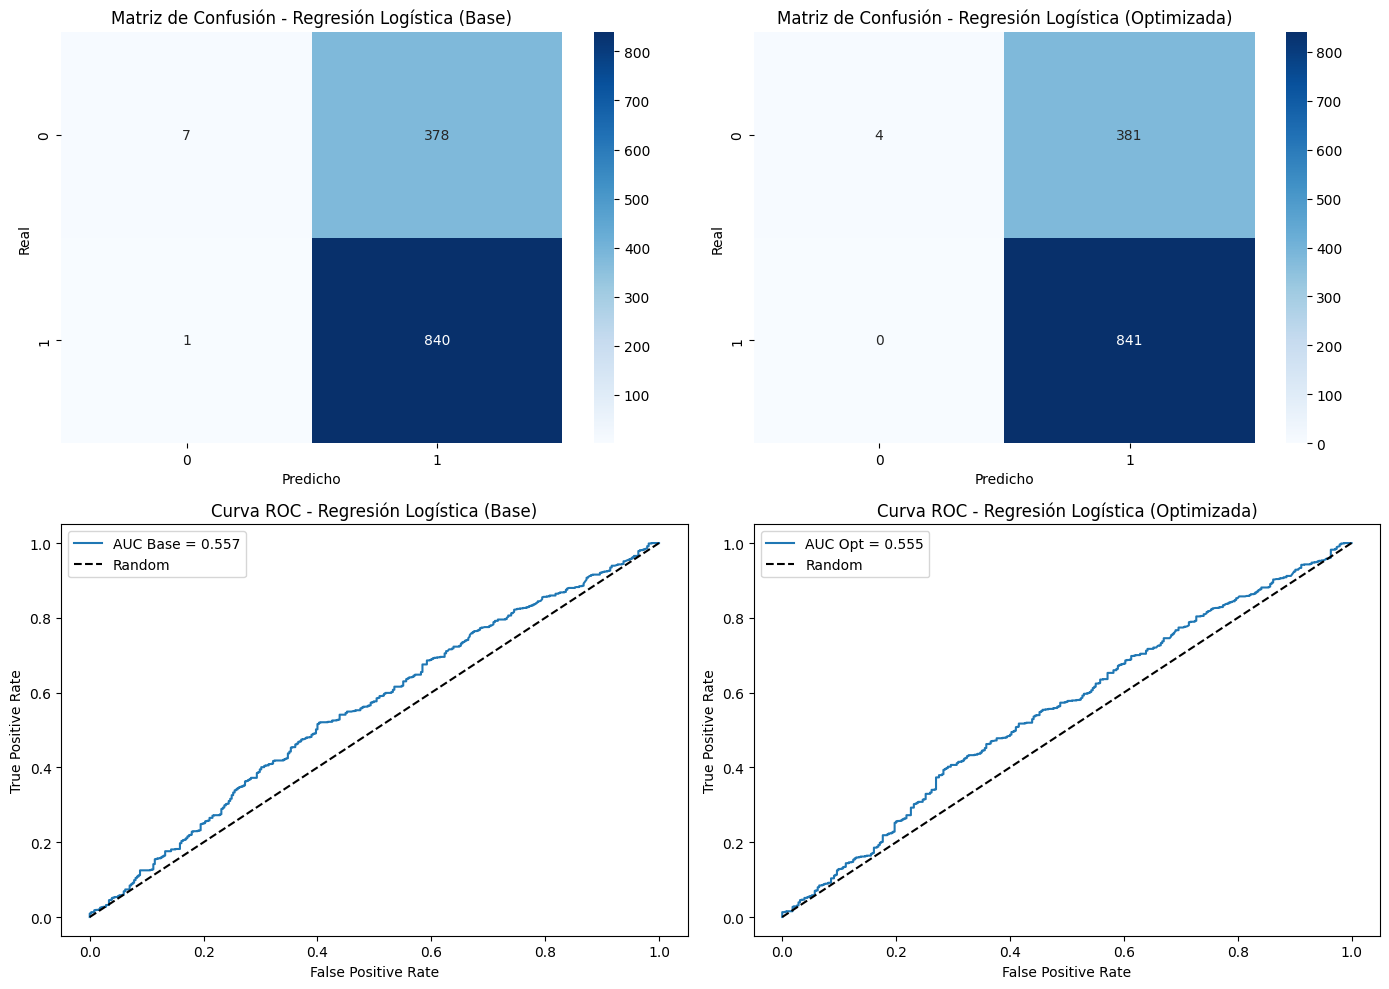

In [57]:
# Gráficas de Regresión Logística: Base vs Optimizada
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- BASE: Matriz de confusión ---
cm_lr_base = confusion_matrix(y_test, y_pred_lr_base)
sns.heatmap(cm_lr_base, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Matriz de Confusión - Regresión Logística (Base)')
axes[0, 0].set_ylabel('Real')
axes[0, 0].set_xlabel('Predicho')

# --- OPT: Matriz de confusión ---
cm_lr_opt = confusion_matrix(y_test, y_pred_lr_opt)
sns.heatmap(cm_lr_opt, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Matriz de Confusión - Regresión Logística (Optimizada)')
axes[0, 1].set_ylabel('Real')
axes[0, 1].set_xlabel('Predicho')

# --- Curvas ROC (solo binaria) ---
if len(np.unique(y)) == 2:
    # BASE
    fpr_b, tpr_b, _ = roc_curve(y_test, y_proba_lr_base[:, 1])
    auc_b = roc_auc_score(y_test, y_proba_lr_base[:, 1])
    axes[1, 0].plot(fpr_b, tpr_b, label=f'AUC Base = {auc_b:.3f}')
    axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1, 0].set_title('Curva ROC - Regresión Logística (Base)')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].legend()

    # OPT
    fpr_o, tpr_o, _ = roc_curve(y_test, y_proba_lr_opt[:, 1])
    auc_o = roc_auc_score(y_test, y_proba_lr_opt[:, 1])
    axes[1, 1].plot(fpr_o, tpr_o, label=f'AUC Opt = {auc_o:.3f}')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1, 1].set_title('Curva ROC - Regresión Logística (Optimizada)')
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].legend()
else:
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## **Árbol de Decisión**

In [58]:

dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train, y_train)
y_pred_dt_base = dt_base.predict(X_test)

print("\n Árbol de Decisión (sin poda)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_base):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_dt_base))


param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

print(f"\nMejores parámetros (pre-pruning): {grid_dt.best_params_}")
print(f"Mejor score (CV Recall): {grid_dt.best_score_:.3f}")


y_pred_dt_opt = grid_dt.predict(X_test)
y_proba_dt_opt = grid_dt.predict_proba(X_test)

print("\n Árbol de Decisión (pre-pruning)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_opt):.3f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_dt_opt))


 Árbol de Decisión (sin poda)
Accuracy: 0.622

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.40      0.42      0.41       385
           1       0.73      0.71      0.72       841

    accuracy                           0.62      1226
   macro avg       0.57      0.57      0.57      1226
weighted avg       0.63      0.62      0.62      1226

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Mejores parámetros (pre-pruning): {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor score (CV Recall): 0.699

 Árbol de Decisión (pre-pruning)
Accuracy: 0.691

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.52      0.26      0.35       385
           1       0.72      0.89      0.80       841

    accuracy                           0.69      1226
   macro avg       0.62      0.57      0.57      1226
weighted avg       0.66      0.69

                  Modelo  Accuracy  Precision   Recall  F1-Score
         Base (sin poda)  0.622349   0.626875 0.622349  0.624500
Optimizado (pre-pruning)  0.690865   0.658402 0.690865  0.655638


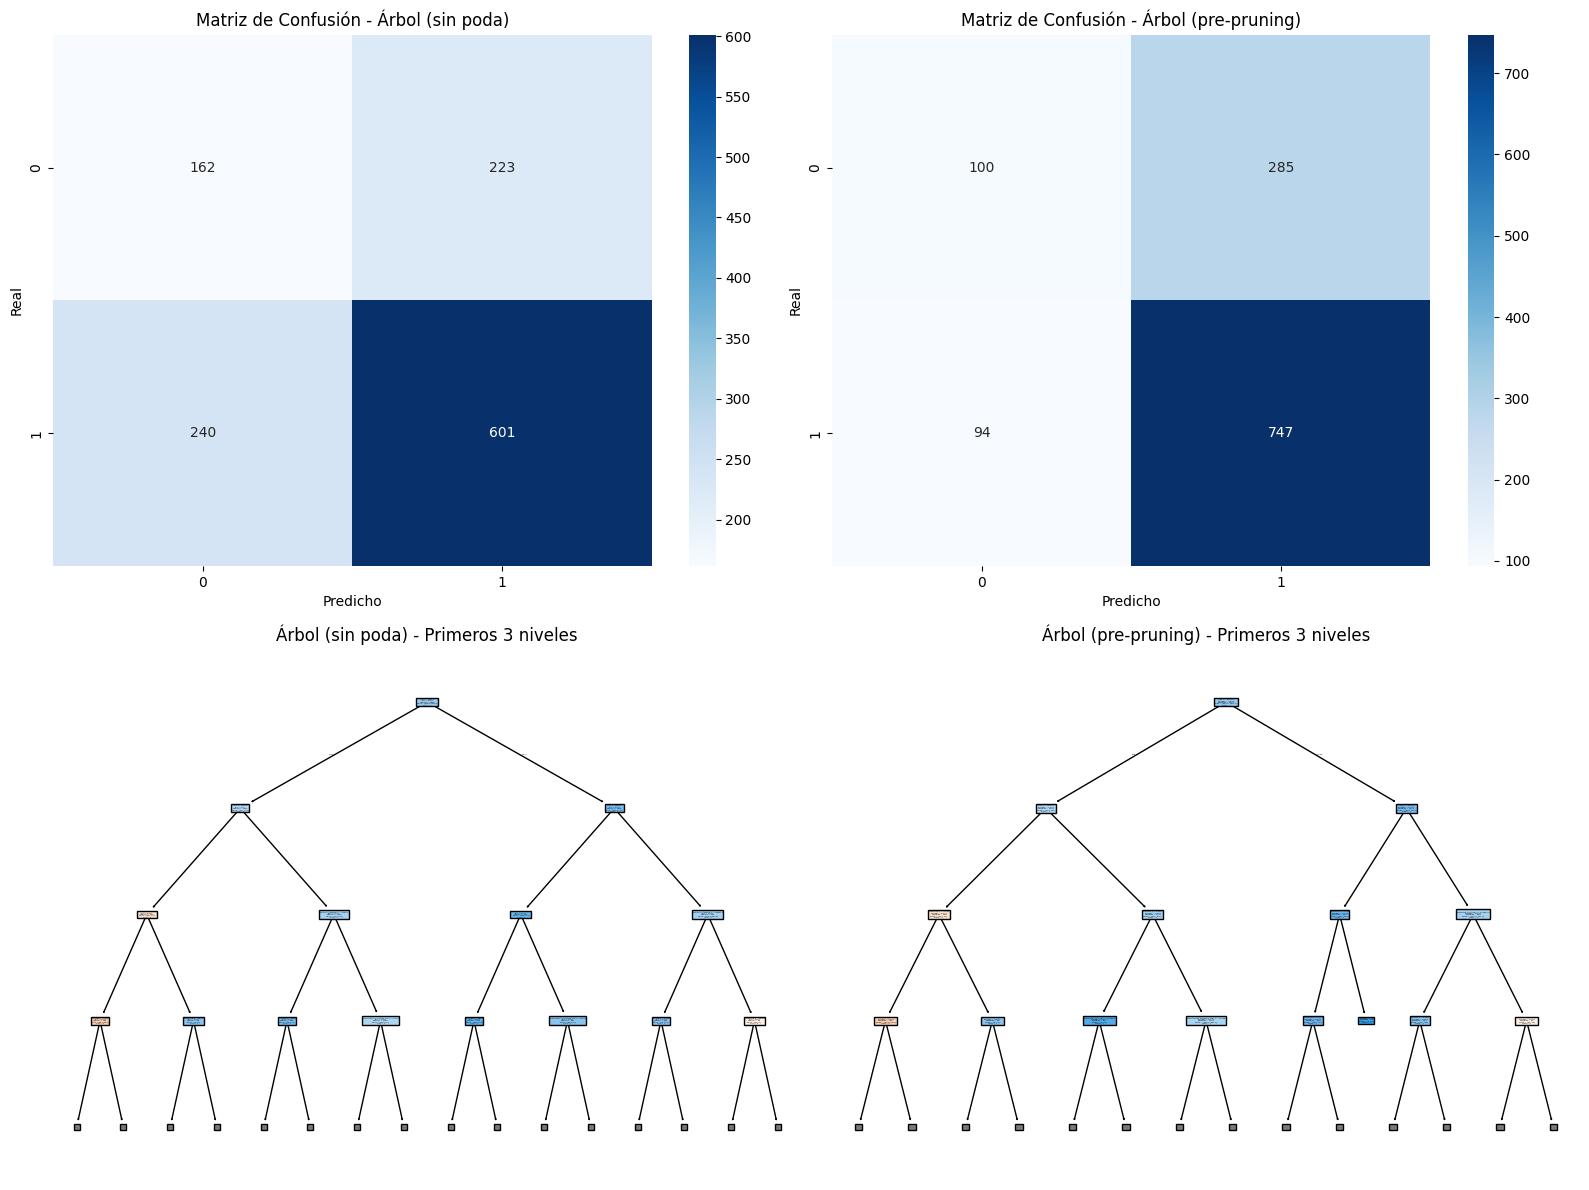

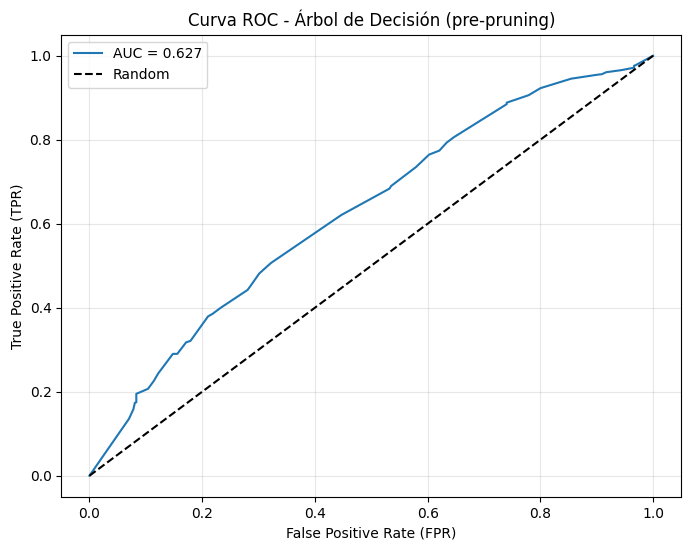

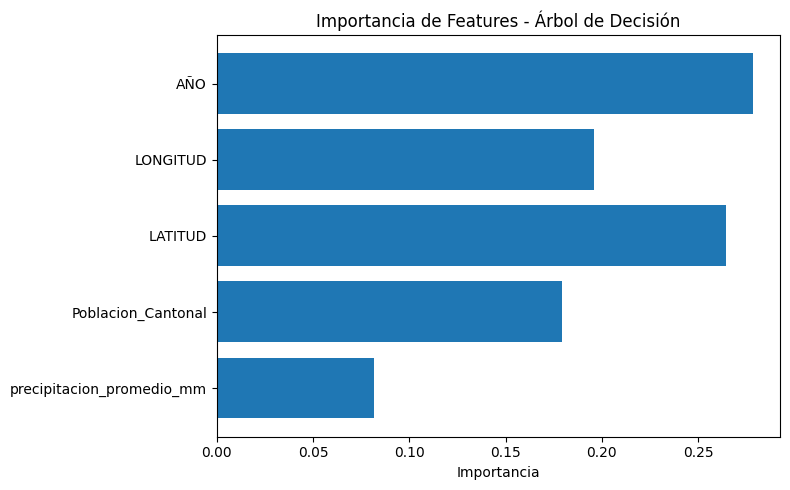

In [59]:
comparacion_dt = pd.DataFrame({
    'Modelo': ['Base (sin poda)', 'Optimizado (pre-pruning)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt_base),
        accuracy_score(y_test, y_pred_dt_opt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_dt_base, average='weighted'),
        precision_score(y_test, y_pred_dt_opt, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_dt_base, average='weighted'),
        recall_score(y_test, y_pred_dt_opt, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_dt_base, average='weighted'),
        f1_score(y_test, y_pred_dt_opt, average='weighted')
    ]
})
print(comparacion_dt.to_string(index=False))


fig, axes = plt.subplots(2, 2, figsize=(16, 12))


cm_dt_base = confusion_matrix(y_test, y_pred_dt_base)
sns.heatmap(cm_dt_base, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Matriz de Confusión - Árbol (sin poda)')
axes[0, 0].set_ylabel('Real')
axes[0, 0].set_xlabel('Predicho')


cm_dt_opt = confusion_matrix(y_test, y_pred_dt_opt)
sns.heatmap(cm_dt_opt, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('Matriz de Confusión - Árbol (pre-pruning)')
axes[0, 1].set_ylabel('Real')
axes[0, 1].set_xlabel('Predicho')


plot_tree(dt_base,
          max_depth=3,
          filled=True,
          feature_names=X.columns,
          class_names=[str(c) for c in np.unique(y)],
          ax=axes[1, 0])
axes[1, 0].set_title('Árbol (sin poda) - Primeros 3 niveles')


plot_tree(grid_dt.best_estimator_,
          max_depth=3,
          filled=True,
          feature_names=X.columns,
          class_names=[str(c) for c in np.unique(y)],
          ax=axes[1, 1])
axes[1, 1].set_title('Árbol (pre-pruning) - Primeros 3 niveles')

plt.tight_layout()
plt.show()


if len(np.unique(y)) == 2:
    plt.figure(figsize=(8, 6))
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt_opt[:, 1])
    auc_dt = roc_auc_score(y_test, y_proba_dt_opt[:, 1])

    plt.plot(fpr_dt, tpr_dt, label=f'AUC = {auc_dt:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Curva ROC - Árbol de Decisión (pre-pruning)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


importances = grid_dt.best_estimator_.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(X.columns, importances)
plt.xlabel('Importancia')
plt.title('Importancia de Features - Árbol de Decisión')
plt.tight_layout()
plt.show()

## **Modelos Guardados para Ensamble**

In [60]:

if recall_score(y_test, y_pred_lr_base, average='weighted') > \
   recall_score(y_test, y_pred_lr_opt, average='weighted'):
    mejor_lr = lr_base
    print("mejor_lr: RL Base (mejor Recall)")
else:
    mejor_lr = grid_lr.best_estimator_
    print("mejor_rl: RL Optimizada")
if recall_score(y_test, y_pred_dt_base, average='weighted') > \
   recall_score(y_test, y_pred_dt_opt, average='weighted'):
    mejor_dt = dt_base
    print("mejor_dt: DT Base (mejor Recall)")
else:
    mejor_dt = grid_dt.best_estimator_
    print("mejor_dt: DT Optimizado")

mejor_lr: RL Base (mejor Recall)
mejor_dt: DT Optimizado


In [61]:
print("MODELOS SELECCIONADOS PARA ENSAMBLE")
print(f"RL: {'Base' if mejor_lr == lr_base else 'Optimizada'}")
print(f"DT: {'Base' if mejor_dt == dt_base else 'Optimizado'}")

MODELOS SELECCIONADOS PARA ENSAMBLE
RL: Base
DT: Optimizado


## **Resumen de Resultados**

In [62]:
resumen_final = pd.DataFrame({
    'Modelo': [
        'Regresión Logística (Base)',
        'Regresión Logística (Optimizada)',
        'Árbol de Decisión (Base)',
        'Árbol de Decisión (Optimizado)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr_base),
        accuracy_score(y_test, y_pred_lr_opt),
        accuracy_score(y_test, y_pred_dt_base),
        accuracy_score(y_test, y_pred_dt_opt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr_base, average='weighted'),
        precision_score(y_test, y_pred_lr_opt, average='weighted'),
        precision_score(y_test, y_pred_dt_base, average='weighted'),
        precision_score(y_test, y_pred_dt_opt, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr_base, average='weighted'),
        recall_score(y_test, y_pred_lr_opt, average='weighted'),
        recall_score(y_test, y_pred_dt_base, average='weighted'),
        recall_score(y_test, y_pred_dt_opt, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr_base, average='weighted'),
        f1_score(y_test, y_pred_lr_opt, average='weighted'),
        f1_score(y_test, y_pred_dt_base, average='weighted'),
        f1_score(y_test, y_pred_dt_opt, average='weighted')
    ]
})

print(resumen_final.to_string(index=False))


mejor_idx = resumen_final['Recall'].idxmax()
print(f"\nMejor modelo (por Recall): {resumen_final.loc[mejor_idx, 'Modelo']}")
print(f"Recall: {resumen_final.loc[mejor_idx, 'Recall']:.3f}")

                          Modelo  Accuracy  Precision   Recall  F1-Score
      Regresión Logística (Base)  0.690865   0.747859 0.690865  0.570891
Regresión Logística (Optimizada)  0.689233   0.786125 0.689233  0.565742
        Árbol de Decisión (Base)  0.622349   0.626875 0.622349  0.624500
  Árbol de Decisión (Optimizado)  0.690865   0.658402 0.690865  0.655638

Mejor modelo (por Recall): Regresión Logística (Base)
Recall: 0.691


## **MODELO AVANZADO, OPTIMIZACIÓN Y MÉTRICAS**

In [63]:

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}


grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='recall_weighted',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_scaled, y_train)

best_rf_model = grid_rf.best_estimator_

print(f"Mejores parámetros RF: {grid_rf.best_params_}")
print(f"Mejor Recall (Weighted) en CV: {grid_rf.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros RF: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Mejor Recall (Weighted) en CV: 0.7054


In [64]:
y_pred_rf = best_rf_model.predict(X_test_scaled)
y_prob_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Desempeño Random Forest en Test ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_prob_rf):.4f}")


--- Desempeño Random Forest en Test ---
Accuracy:  0.7104
Precision: 0.6873
Recall:    0.7104
F1-Score:  0.6606
AUC:       0.6955


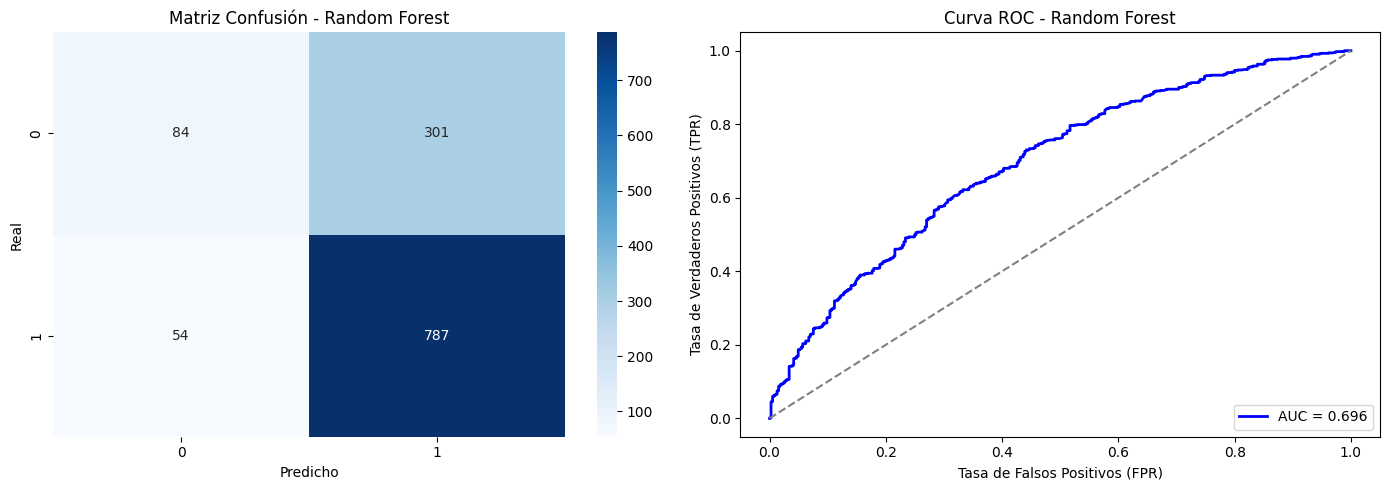

In [65]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz Confusión - Random Forest')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_val = roc_auc_score(y_test, y_prob_rf)
axes[1].plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'AUC = {auc_val:.3f}')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--') # Línea de azar
axes[1].set_title('Curva ROC - Random Forest')
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()



In [66]:
final_lr = mejor_lr
final_dt = mejor_dt
final_rf = best_rf_model


voting_clf = VotingClassifier(
    estimators=[
        ('lr', final_lr),
        ('dt', final_dt),
        ('rf', final_rf)
    ],
    voting='soft'
)


voting_clf.fit(X_train_scaled, y_train)


y_pred_vote = voting_clf.predict(X_test_scaled)
y_prob_vote = voting_clf.predict_proba(X_test_scaled)[:, 1]

print("Ensamble entrenado exitosamente.")
print("\n--- Desempeño Ensamble en Test ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_vote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_vote, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_vote, average='weighted'):.4f}")
print(f"f1-Score: {f1_score(y_test, y_pred_vote, average='weighted'):.4f}")
print(f"AUC:       {roc_auc_score(y_test, y_prob_vote):.4f}")

Ensamble entrenado exitosamente.

--- Desempeño Ensamble en Test ---
Accuracy:  0.6998
Precision: 0.6712
Recall:    0.6998
f1-Score: 0.6321
AUC:       0.6624


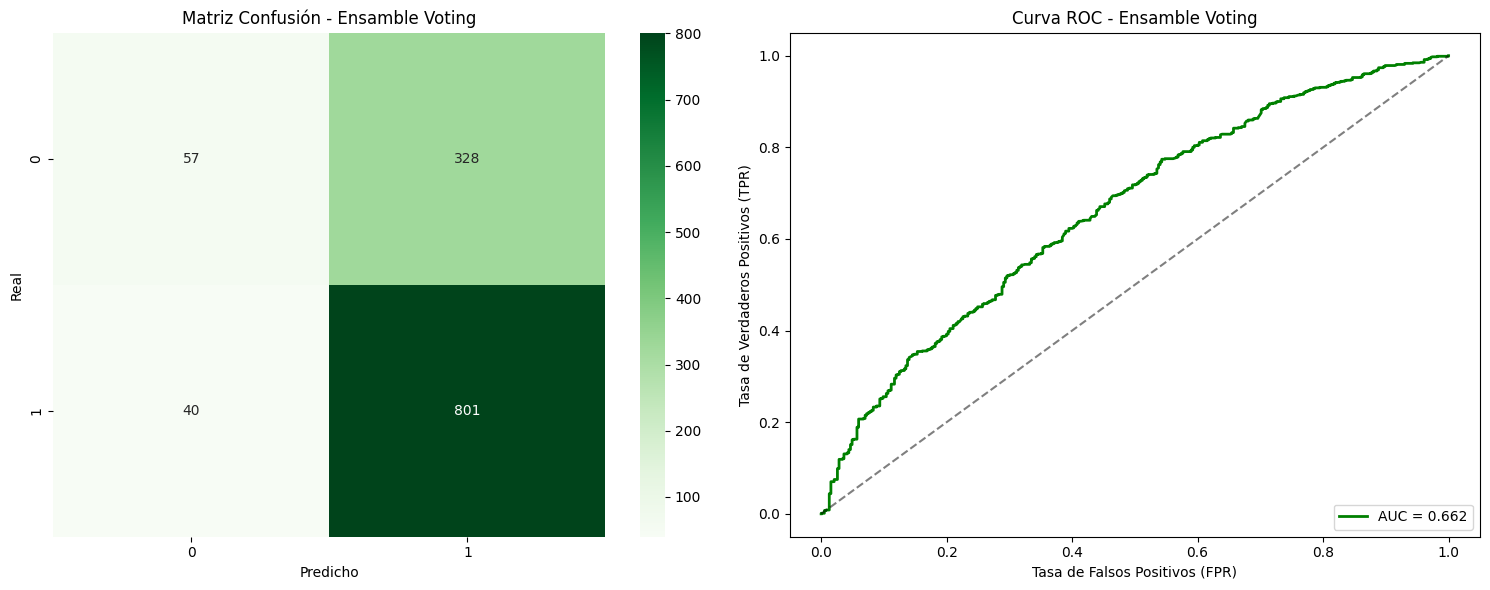

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))


sns.heatmap(confusion_matrix(y_test, y_pred_vote),
            annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Matriz Confusión - Ensamble Voting')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicho')


fpr_v, tpr_v, _ = roc_curve(y_test, y_prob_vote)
auc_v = roc_auc_score(y_test, y_prob_vote)

axes[1].plot(fpr_v, tpr_v, color='green', lw=2, label=f'AUC = {auc_v:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_title('Curva ROC - Ensamble Voting')
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [68]:
def get_metrics(model_name, y_true, y_pred, y_prob=None):
    res = {
        'Modelo': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (W)': precision_score(y_true, y_pred, average='weighted'),
        'Recall (W)': recall_score(y_true, y_pred, average='weighted'),
        'F1-Score (W)': f1_score(y_true, y_pred, average='weighted')
    }
    if y_prob is not None:
        try:
            res['AUC'] = roc_auc_score(y_true, y_prob)
        except ValueError:
            res['AUC'] = 0.0
    else:
        res['AUC'] = 0.0
    return res

In [69]:
resultados = []


y_pred_lr = mejor_lr.predict(X_test_scaled)
y_prob_lr = mejor_lr.predict_proba(X_test_scaled)[:, 1]

resultados.append(
    get_metrics(
        'Regresión Logística',
        y_test,
        y_pred_lr,
        y_prob_lr
    )
)


y_pred_dt = mejor_dt.predict(X_test)
y_prob_dt = mejor_dt.predict_proba(X_test)[:, 1]

resultados.append(
    get_metrics(
        'Árbol de Decisión',
        y_test,
        y_pred_dt,
        y_prob_dt
    )
)


resultados.append(
    get_metrics(
        'Random Forest',
        y_test,
        y_pred_rf,
        y_prob_rf
    )
)


resultados.append(
    get_metrics(
        'Ensamble (Voting)',
        y_test,
        y_pred_vote,
        y_prob_vote
    )
)

df_resumen = pd.DataFrame(resultados).set_index('Modelo')
print("\n=== TABLA COMPARATIVA FINAL DE MÉTRICAS ===")
print(df_resumen.round(4))


=== TABLA COMPARATIVA FINAL DE MÉTRICAS ===
                     Accuracy  Precision (W)  Recall (W)  F1-Score (W)     AUC
Modelo                                                                        
Regresión Logística    0.6909         0.7479      0.6909        0.5709  0.5573
Árbol de Decisión      0.6909         0.6584      0.6909        0.6556  0.6268
Random Forest          0.7104         0.6873      0.7104        0.6606  0.6955
Ensamble (Voting)      0.6998         0.6712      0.6998        0.6321  0.6624


In [70]:
modelo_final = best_rf_model
X_eval = X_test_scaled
usa_prob = True


y_pred_final = modelo_final.predict(X_eval)
y_prob_final = modelo_final.predict_proba(X_eval)[:, 1] if usa_prob else None


df_export = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred_final
})

if y_prob_final is not None:
    df_export["y_prob"] = y_prob_final


output_path = "predicciones_modelo_final.csv"
df_export.to_csv(output_path, index=False)
print(f"\nPredicciones exportadas a: {output_path}")


Predicciones exportadas a: predicciones_modelo_final.csv


#**Arbol de decision vs Regresion Logistica**

Ambos modelos presentan la misma Accuracy (0.6909), pero difieren en su capacidad para identificar correctamente los casos de riesgo. La Regresión Logística tiene una Precisión alta (0.7479), pero su Recall es 0.6909 y su AUC es bajo (0.5573), lo que indica dificultades para detectar todos los eventos de riesgo.
El Árbol de Decisión alcanza el mismo Recall (0.6909), pero con un AUC mayor (0.6268) y un F1-Score superior (0.6556), mostrando un comportamiento más equilibrado y una mejor capacidad de discriminación entre clases, lo que lo hace más adecuado en un contexto de riesgo.

#**Random Forest vs Ensamble**

Al comparar el Random Forest con el Ensamble, se observa que el Random Forest presenta el mejor desempeño en la métrica prioritaria del proyecto, el Recall, alcanzando un valor de 0.7104, superior al obtenido por el Ensamble (0.6998). Esto indica que el Random Forest identifica una mayor proporción de parroquias en riesgo, reduciendo de forma más efectiva los falsos negativos, que son críticos en escenarios de gestión de inundaciones.

Adicionalmente, el Random Forest obtiene el AUC más alto (0.6955), lo que evidencia una mejor capacidad de discriminación entre clases frente al Ensamble (0.6624). Aunque el Ensamble combina varios modelos, su F1-Score (0.6321) es inferior al del Random Forest (0.6606), lo que sugiere que la combinación no logró optimizar el equilibrio entre precisión y sensibilidad.

En conjunto, los resultados muestran que el Random Forest ofrece un desempeño más robusto y consistente que el Ensamble, siendo más eficaz para detectar eventos de riesgo sin sacrificar estabilidad en las métricas, lo que lo consolida como la mejor alternativa para el objetivo del proyecto.

#**Conclusiones**

Selección del Modelo Final y Prioridad del Recall:

En la gestión de riesgo de inundaciones, la métrica prioritaria es el Recall, ya que los falsos negativos (no detectar una parroquia en riesgo real) tienen consecuencias graves en términos de vidas humanas y daños materiales.
Los falsos positivos, en cambio, solo implican medidas preventivas adicionales.

El Random Forest presenta el mayor Recall (0.7104) entre todos los modelos evaluados, lo que significa que detecta la mayor proporción de eventos de riesgo reales.
Este desempeño, junto con su AUC elevado y un F1-Score equilibrado, lo convierte en el modelo más confiable para un sistema de alerta temprana.

El Random Forest optimizado es el modelo recomendado, ya que prioriza correctamente el Recall, minimiza los falsos negativos y mantiene un buen equilibrio con las demás métricas.
Accuracy, F1-Score y AUC se utilizan como métricas de soporte, pero la decisión final se fundamenta en el Recall, en concordancia con los objetivos de la gestión de riesgo.

In [71]:
print("1. Cargando estructura del mapa...")
# Mapa base
url_geojson = 'https://drive.google.com/uc?export=download&id=1u8uvcR8Mf5U3bXqbu8Qv2wiKJuhilCbJ'
r = requests.get(url_geojson)
geojson_data = r.json()

lista_parroquias = []
for feature in geojson_data['features']:
    props = feature['properties']
    lista_parroquias.append({
        'dpa_parroquia': str(props['DPA_PARROQ']).zfill(6),
        'dpa_canton': str(props['DPA_CANTON']).zfill(4),
        'nombre': props['DPA_DESPAR']
    })
df_final = pd.DataFrame(lista_parroquias)
df_final['pcode_canton'] = 'EC' + df_final['dpa_canton']

# Obtener coordenadas representativas por pcode_canton del df_limpio
# Esto asegura que tengamos LATITUD y LONGITUD consistentes con el contexto de los datos de entrenamiento
canton_coords = df_limpio.groupby('pcode_canton')[['LATITUD', 'LONGITUD']].mean().reset_index()
df_final = df_final.merge(canton_coords, on='pcode_canton', how='left')

print("2. Preparando datos de clima y población...")

# Datos Climáticos (Rellenar con el promedio si no hay dato, no con 0)
if 'df_clima_canton' in locals():
    clima = df_clima_canton.groupby('PCODE')['precipitacion_promedio_mm'].mean().reset_index()
    df_final = df_final.merge(clima, left_on='pcode_canton', right_on='PCODE', how='left')
    mean_precip = df_final['precipitacion_promedio_mm'].mean()
    df_final['precipitacion_promedio_mm'] = df_final['precipitacion_promedio_mm'].fillna(mean_precip)
else:
    print("ADVERTENCIA: df_clima_canton no encontrado.")
    df_final['precipitacion_promedio_mm'] = 0.0 # Default if no climate data

# Datos Población
if 'df_postal_canton' in locals():
    # FIX: Use 'Poblacion' column and then rename it
    pob = df_postal_canton.groupby('pcode_canton')['Poblacion'].mean().reset_index()
    pob.rename(columns={'Poblacion': 'Poblacion_Cantonal'}, inplace=True)
    df_final = df_final.merge(pob, on='pcode_canton', how='left')
    mean_pob = df_final['Poblacion_Cantonal'].mean()
    df_final['Poblacion_Cantonal'] = df_final['Poblacion_Cantonal'].fillna(mean_pob)
else:
    print("ADVERTENCIA: df_postal_canton no encontrado.")
    df_final['Poblacion_Cantonal'] = 0.0 # Default if no population data

# Add the 'AÑO' feature. Use the latest year from the original data for consistency.
latest_year = df_limpio['AÑO'].max()
df_final['AÑO'] = latest_year

# Impute any remaining NaNs for LATITUD and LONGITUD if any exist after merge (unlikely if canton_coords is complete)
df_final['LATITUD'] = df_final['LATITUD'].fillna(df_final['LATITUD'].mean())
df_final['LONGITUD'] = df_final['LONGITUD'].fillna(df_final['LONGITUD'].mean())

print("3. Generando Predicciones del Modelo ")
features = ['precipitacion_promedio_mm', 'Poblacion_Cantonal', 'LATITUD', 'LONGITUD', 'AÑO']
X_pred_all_parroquias = df_final[features]

if 'scaler' not in locals():
    raise NameError("El objeto 'scaler' no está definido. Asegúrate de que la celda de escalado ha sido ejecutada.")
X_pred_scaled = scaler.transform(X_pred_all_parroquias)

if 'best_rf_model' not in locals():
    raise NameError("El objeto 'best_rf_model' no está definido. Asegúrate de que el modelo Random Forest ha sido entrenado y guardado.")

probs_modelo = best_rf_model.predict_proba(X_pred_scaled)[:, 1]

# APLICANDO  FILTRO HÍBRIDO
print("4. Aplicando Filtro Inteligente (Rural vs Urbano, basado en historial)... ")

if 'df' in locals():
    # Historial por PARROQUIA (Muy específico)
    historial_parroquias = set(df['CODIFICACION PARROQUIAL'].astype(str).str.zfill(6).unique())
    # Historial por CANTÓN (General)
    historial_cantones = set(df['CODIFICACION CANTONAL'].astype(str).str.zfill(4).unique())

    def calcular_riesgo_final(fila, prob_modelo_raw):
        parr_id = fila['dpa_parroquia']
        cant_id = fila['dpa_canton']

        # ¿Es Cabecera Cantonal (Ciudad)? Suelen terminar en '50'
        es_urbana = parr_id.endswith('50')

        tiene_historia_parroquia = parr_id in historial_parroquias
        tiene_historia_canton = cant_id in historial_cantones

        # REGLA 1: Zonas Urbanas (Ciudades)
        # Si es ciudad y el cantón es peligroso -> CONFIAMOS EN EL MODELO (Riesgo Alto)
        if es_urbana and tiene_historia_canton:
            return prob_modelo_raw

        # REGLA 2: Zonas Rurales (El campo)
        # Solo marcamos riesgo si ESA parroquia específica tiene historia
        if not es_urbana and tiene_historia_parroquia:
            return prob_modelo_raw

        # REGLA 3: Si no cumple lo anterior -> RIESGO CERO (Seguro)
        # Esto limpiará todo el "ruido" del mapa
        return 0.0

    # Aplicamos la función fila por fila
    df_final['y_prob'] = [calcular_riesgo_final(row, prob) for row, prob in zip(df_final.to_dict('records'), probs_modelo)]

    # Recalcular binario (0 o 1)
    df_final['y_pred'] = np.where(df_final['y_prob'] > 0.4, 1, 0)

else:
    print(" No se encontró 'df' (Base de Eventos). No se pudo filtrar por historia. Usando solo el modelo.")
    df_final['y_prob'] = probs_modelo
    df_final['y_pred'] = np.where(probs_modelo > 0.5, 1, 0)

#  Guardar
df_exportar = df_final[['dpa_parroquia', 'y_pred', 'y_prob']]
# Eliminar cualquier duplicado final
df_exportar = df_exportar.drop_duplicates(subset=['dpa_parroquia'])
df_exportar.to_csv('predicciones_nacional_completo.csv', index=False)

print(f" CSV Generado: predicciones_nacional_completo.csv")
print(f"Total Parroquias: {len(df_exportar)}")
print(f"Zonas en Riesgo (1): {df_exportar['y_pred'].sum()}")
print(f"Zonas Seguras (0): {len(df_exportar) - df_exportar['y_pred'].sum()}")

1. Cargando estructura del mapa...
2. Preparando datos de clima y población...
3. Generando Predicciones del Modelo 
4. Aplicando Filtro Inteligente (Rural vs Urbano, basado en historial)... 
 CSV Generado: predicciones_nacional_completo.csv
Total Parroquias: 1036
Zonas en Riesgo (1): 679
Zonas Seguras (0): 357


In [73]:
# CONFIGURACIÓN DE ARCHIVOS
ID_JSON_DRIVE = '1u8uvcR8Mf5U3bXqbu8Qv2wiKJuhilCbJ'
ID_CSV_DRIVE = '1CMFX_z2xlSvsTeRgjYtP2W4hZbF7Nixk'

NOMBRE_JSON = 'ORGANIZACION TERRITORIAL DEL ESTADO PARROQUIAL (1).json'
NOMBRE_CSV = 'predicciones_nacional_completo.csv'

def descargar_de_drive(file_id, output_path):
    if os.path.exists(output_path): return
    url = f'https://drive.google.com/uc?export=download&id={file_id}'
    try:
        response = requests.get(url)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                f.write(response.content)
            print(f"Archivo listo: {output_path}")
    except Exception as e:
        print(f"Error: {e}")

# Preparar carpetas
os.makedirs('static', exist_ok=True)
descargar_de_drive(ID_JSON_DRIVE, f'static/{NOMBRE_JSON}')
descargar_de_drive(ID_CSV_DRIVE, f'static/{NOMBRE_CSV}')

html_maestro = """
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>Mapa de Riesgo Ecuador</title>
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.9.4/dist/leaflet.css" />
    <style>
        body { margin: 0; font-family: 'Segoe UI', sans-serif; background: #f0f2f5; }
        .header { background: #001f3f; color: white; padding: 10px; text-align: center; }
        .controls {
            display: flex; flex-wrap: wrap; gap: 15px; padding: 15px;
            background: white; justify-content: center; align-items: center;
            border-bottom: 2px solid #ddd;
        }
        select, input { padding: 10px; border-radius: 5px; border: 1px solid #ccc; width: 200px; }
        button { padding: 10px 15px; cursor: pointer; background: #001f3f; color: white; border: none; border-radius: 5px; }
        button:hover { background: #003366; }
        #map { height: 80vh; width: 100%; }

        .info.legend {
            background: rgba(255,255,255,0.95); padding: 12px; border-radius: 8px;
            line-height: 22px; border: 2px solid #001f3f;
        }
        .info.legend i { width: 20px; height: 20px; float: left; margin-right: 8px; border: 1px solid #999; }
    </style>
</head>
<body>
    <div class="header"><h2>Análisis de Riesgo por Parroquia</h2></div>

    <div class="controls">
        <select id="prov"><option value="">Provincia...</option></select>
        <select id="can" disabled><option value="">Cantón...</option></select>
        <select id="par" disabled><option value="">Parroquia...</option></select>
        <input type="text" id="busqueda" placeholder="Buscar parroquia (ej: oyeturo)...">
        <button onclick="buscarInteligente()">Buscar</button>
        <button onclick="location.reload()" style="background: #666;">Reiniciar</button>
    </div>

    <div id="map"></div>

    <script src="https://unpkg.com/leaflet@1.9.4/dist/leaflet.js"></script>
    <script>
        var map = L.map('map').setView([-1.83, -78.18], 7);
        L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png').addTo(map);

        var geoLayer, riskData = {}, parroquiasLista = [];

        function getColor(d) {
            return d === 0    ? '#FFEDA0' :
                   d <= 0.2  ? '#FD8D3C' :
                   d <= 0.4  ? '#FC4E2A' :
                   d <= 0.6  ? '#E31A1C' :
                   d <= 0.8  ? '#BD0026' : '#800026';
        }

        // NUEVA: Función para etiquetas de texto
        function getRiskLabel(p) {
            if (p === 0) return "Nulo / Sin Datos";
            if (p <= 0.33) return "Riesgo Bajo";
            if (p <= 0.66) return "Riesgo Medio";
            return "Riesgo Alto";
        }

        var legend = L.control({position: 'topright'});
        legend.onAdd = function (map) {
            var div = L.DomUtil.create('div', 'info legend');
            div.innerHTML = '<strong>Nivel de Riesgo</strong><br>' +
                '<i style="background:#FFEDA0"></i> 0%<br><i style="background:#FD8D3C"></i> > 0%<br>' +
                '<i style="background:#FC4E2A"></i> ≤ 40%<br><i style="background:#E31A1C"></i> ≤ 60%<br>' +
                '<i style="background:#BD0026"></i> ≤ 80%<br><i style="background:#800026"></i> > 80%';
            return div;
        };
        legend.addTo(map);

        function similitud(s1, s2) {
            s1 = s1.toLowerCase().normalize("NFD").replace(/[\u0300-\u036f]/g, "");
            s2 = s2.toLowerCase().normalize("NFD").replace(/[\u0300-\u036f]/g, "");
            var costs = new Array();
            for (var i = 0; i <= s1.length; i++) {
                var lastValue = i;
                for (var j = 0; j <= s2.length; j++) {
                    if (i == 0) costs[j] = j;
                    else {
                        if (j > 0) {
                            var newValue = costs[j - 1];
                            if (s1.charAt(i - 1) != s2.charAt(j - 1))
                                newValue = Math.min(Math.min(newValue, lastValue), costs[j]) + 1;
                            costs[j - 1] = lastValue; lastValue = newValue;
                        }
                    }
                }
                if (i > 0) costs[s2.length] = lastValue;
            }
            return costs[s2.length];
        }

        function buscarInteligente() {
            var entrada = document.getElementById('busqueda').value;
            if (!entrada) return;
            var mejorCoincidencia = null, menorDistancia = 999;
            parroquiasLista.forEach(p => {
                var d = similitud(entrada, p.nombre);
                if (d < menorDistancia) { menorDistancia = d; mejorCoincidencia = p; }
            });

            if (mejorCoincidencia && menorDistancia < 5) {
                geoLayer.eachLayer(l => {
                    if(l.feature.properties.DPA_PARROQ === mejorCoincidencia.id) {
                        map.fitBounds(l.getBounds());
                        l.openPopup();
                        document.getElementById('prov').value = l.feature.properties.DPA_DESPRO;
                        document.getElementById('prov').dispatchEvent(new Event('change'));
                        setTimeout(() => {
                            document.getElementById('can').value = l.feature.properties.DPA_DESCAN;
                            document.getElementById('can').dispatchEvent(new Event('change'));
                            setTimeout(() => { document.getElementById('par').value = l.feature.properties.DPA_PARROQ; }, 100);
                        }, 100);
                    }
                });
            }
        }

        Promise.all([
            fetch(encodeURI('/static/{{NOMBRE_JSON}}')).then(r => r.json()),
            fetch(encodeURI('/static/{{NOMBRE_CSV}}')).then(r => r.text())
        ]).then(([geojsonData, csvText]) => {
            csvText.split('\\n').slice(1).forEach(row => {
                var cols = row.split(',');
                if(cols.length >= 3) {
                    var id = cols[0].trim().padStart(6, '0');
                    riskData[id] = parseFloat(cols[2]);
                }
            });

            geoLayer = L.geoJson(geojsonData, {
                style: (f) => ({
                    fillColor: getColor(riskData[f.properties.DPA_PARROQ] || 0),
                    weight: 0.6, opacity: 1, color: 'white', fillOpacity: 0.7
                }),
                onEachFeature: (f, l) => {
                    var p = riskData[f.properties.DPA_PARROQ] || 0;
                    parroquiasLista.push({ nombre: f.properties.DPA_DESPAR, id: f.properties.DPA_PARROQ });

                    // HOVER (TOOLTIP): Provincia, Cantón y Parroquia
                    l.bindTooltip(
                        '<b>Provincia:</b> ' + f.properties.DPA_DESPRO + '<br>' +
                        '<b>Cantón:</b> ' + f.properties.DPA_DESCAN + '<br>' +
                        '<b>Parroquia:</b> ' + f.properties.DPA_DESPAR
                    );

                    // CLIC (POPUP): Ubicación + Riesgo
                    l.bindPopup(
                        '<div style="text-align:center">' +
                        '<b>PROVINCIA:</b> ' + f.properties.DPA_DESPRO + '<br>' +
                        '<b>CANTÓN:</b> ' + f.properties.DPA_DESCAN + '<br>' +
                        '<b>PARROQUIA:</b> ' + f.properties.DPA_DESPAR + '<hr style="margin:5px 0">' +
                        '<b style="color:' + getColor(p) + '; font-size:1.1em">' + getRiskLabel(p).toUpperCase() + '</b><br>' +
                        'Probabilidad: ' + (p * 100).toFixed(2) + '%' +
                        '</div>'
                    );

                    // ILUMINACIÓN (Highlight)
                    l.on({
                        mouseover: function(e) {
                            var layer = e.target;
                            layer.setStyle({ weight: 3, color: '#666', fillOpacity: 0.9 });
                            layer.bringToFront();
                        },
                        mouseout: function(e) { geoLayer.resetStyle(e.target); }
                    });
                }
            }).addTo(map);

            const selProv = document.getElementById('prov'), selCan = document.getElementById('can'), selPar = document.getElementById('par');
            const provs = [...new Set(geojsonData.features.map(f => f.properties.DPA_DESPRO))].sort();
            provs.forEach(p => selProv.add(new Option(p, p)));

            selProv.onchange = () => {
                selCan.innerHTML = '<option value="">Cantón...</option>';
                selPar.innerHTML = '<option value="">Parroquia...</option>';
                selCan.disabled = !selProv.value; selPar.disabled = true;
                if (selProv.value) {
                    const f = geojsonData.features.filter(x => x.properties.DPA_DESPRO === selProv.value);
                    [...new Set(f.map(x => x.properties.DPA_DESCAN))].sort().forEach(c => selCan.add(new Option(c, c)));
                    map.fitBounds(L.geoJson(f).getBounds());
                }
            };

            selCan.onchange = () => {
                selPar.innerHTML = '<option value="">Parroquia...</option>';
                selPar.disabled = !selCan.value;
                if (selCan.value) {
                    const f = geojsonData.features.filter(x => x.properties.DPA_DESPRO === selProv.value && x.properties.DPA_DESCAN === selCan.value);
                    f.sort((a,b) => a.properties.DPA_DESPAR.localeCompare(b.properties.DPA_DESPAR))
                     .forEach(x => selPar.add(new Option(x.properties.DPA_DESPAR, x.properties.DPA_PARROQ)));
                    map.fitBounds(L.geoJson(f).getBounds());
                }
            };

            selPar.onchange = () => {
                geoLayer.eachLayer(l => {
                    if(l.feature.properties.DPA_PARROQ === selPar.value) { map.fitBounds(l.getBounds()); l.openPopup(); }
                });
            };
        });
    </script>
</body>
</html>
"""

html_maestro = html_maestro.replace("{{NOMBRE_JSON}}", NOMBRE_JSON).replace("{{NOMBRE_CSV}}", NOMBRE_CSV)

app = Flask(__name__)
@app.route('/')
def home(): return render_template_string(html_maestro)

@app.route('/static/<path:filename>')
def serve_static(filename): return send_from_directory('static', filename)

if __name__ == '__main__':
    url = eval_js("google.colab.kernel.proxyPort(5000)")
    print(f"¡DA CLIC AQUÍ ABAJO!")
    print(f"{url.strip()}")
    app.run(port=5000)

Archivo listo: static/ORGANIZACION TERRITORIAL DEL ESTADO PARROQUIAL (1).json
¡DA CLIC AQUÍ ABAJO!
https://5000-m-s-26paw1y0j23gq-b.us-west3-1.prod.colab.dev
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [17/Feb/2026 07:45:37] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Feb/2026 07:45:37] "GET /static/predicciones_nacional_completo.csv HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Feb/2026 07:45:37] "GET /static/ORGANIZACION%20TERRITORIAL%20DEL%20ESTADO%20PARROQUIAL%20(1).json HTTP/1.1" 200 -


Resumen del Proyecto: Mapa de Riesgo de Inundaciones



**1. Visualización Geoespacial e Interfaz**

Se creó una aplicación web interactiva con Flask (Python) y Leaflet.js (JavaScript) para visualizar la probabilidad de inundación en el área parroquial.

Buscador Jerárquico: Implementación de un menú desplegable en cascada (Provincia > Cantón > Parroquia) que filtra los datos en tiempo real e implementa el zoom automático del área seleccionada.



Popups Detallados: Etiquetas informativas que muestran la jerarquía completa (Provincia y Cantón) y el porcentaje de riesgo exacto al clicar en cualquiera de los polígonos.

Leyenda Dinámica: Escala de colores, también llamada Heatmap, se refiere a la probabilidad del modelo. Esta escala va desde el amarillo, que indica un bajo riesgo, hasta el rojo oscuro, que indica un alto riesgo.






**2. Gestión y Persistencia de Datos**

Mejoramos cómo la aplicación maneja la información para que sea un sistema robusto y fácil de compartir.
Los archivos que antes estaban en el ordenador, los hemos pasado a Google Drive. Esto nos permite hacer algo muy útil. Cada vez que el sistema se reinicia, puede bajar automáticamente dos archivos importantes de Google Drive.

El primero es el archivo GeoJSON que tiene toda la información sobre la organización territorial. El segundo es el archivo CSV que contiene las predicciones.


**Enlace público para que cualquier usuario pueda ver el mapa y predicciones**

https://proyecto-inundaciones-grupo-2.onrender.com/